# INF2178 A3
Zhuoying Li
1004021202

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read .csv file
df = pd.read_csv('./INF2178_A3_data.csv')

## Exploratory Data Analysis

In [41]:
# Get some basic summary statistics
print(df.describe())

       fallreadingscore  fallmathscore  fallgeneralknowledgescore  \
count      11933.000000   11933.000000               11933.000000   
mean          35.954215      27.128244                  23.073694   
std           10.473130       9.120505                   7.396978   
min           21.010000      10.510000                   6.985000   
25%           29.340000      20.680000                  17.385000   
50%           34.060000      25.680000                  22.954000   
75%           39.890000      31.590000                  28.305000   
max          138.510000     115.650000                  47.691000   

       springreadingscore  springmathscore  springgeneralknowledgescore  \
count        11933.000000     11933.000000                 11933.000000   
mean            47.511178        37.799461                    28.235584   
std             14.327111        12.027753                     7.577457   
min             22.350000        11.900000                     7.858000   
25%

In [42]:
# Modify the incomegroup column to be an ordered categorical variable
df.incomegroup = pd.Categorical(
    df.incomegroup,
    ordered = True,
    categories = [1,2,3]
)

In [43]:
# Get summary statistics for the various scores by income group
def get_summary_stats(df, col_name):
    print('Summary statistics for ' + col_name + ' by income group')
    print(df.groupby(
        'incomegroup',
        observed=False # Pass observed=False to suppress a deprecation warning
    )[col_name].describe())

In [44]:
score_columns = ['mathscore', 'readingscore', 'generalknowledgescore']
for col in score_columns:
    get_summary_stats(df, 'fall' + col)
    get_summary_stats(df, 'spring' + col)

Summary statistics for fallmathscore by income group
              count       mean       std    min      25%     50%      75%  \
incomegroup                                                                 
1            4729.0  23.924504  7.642412  10.51  18.6100  22.790  27.5700   
2            3726.0  27.568468  8.541161  11.59  21.5200  26.140  31.7800   
3            3478.0  31.012720  9.930977  10.90  24.3725  29.085  35.6675   

                max  
incomegroup          
1             86.33  
2             83.42  
3            115.65  
Summary statistics for springmathscore by income group
              count       mean        std    min      25%     50%      75%  \
incomegroup                                                                  
1            4729.0  33.883051  10.734653  11.90  26.4100  32.270  40.1000   
2            3726.0  38.464691  11.359349  13.14  30.3925  37.035  44.6975   
3            3478.0  42.411898  12.605759  12.70  33.8450  41.030  48.4600   

     

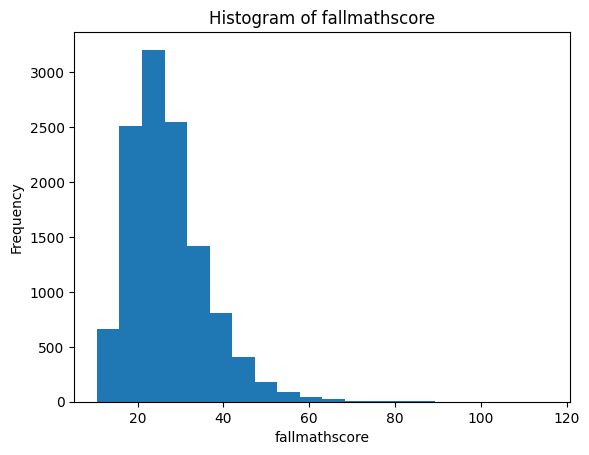

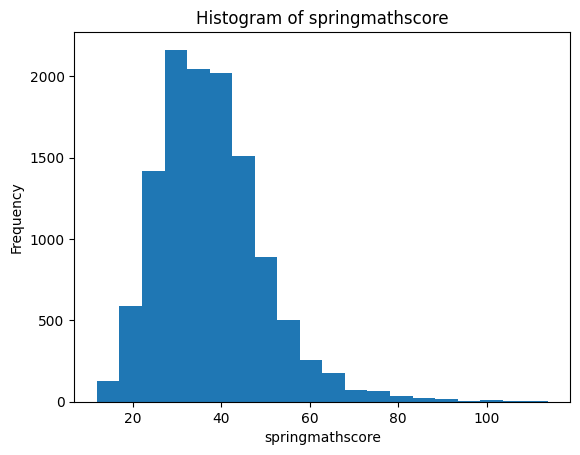

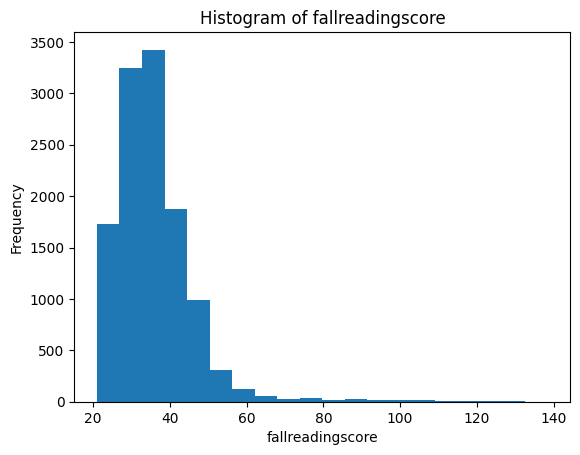

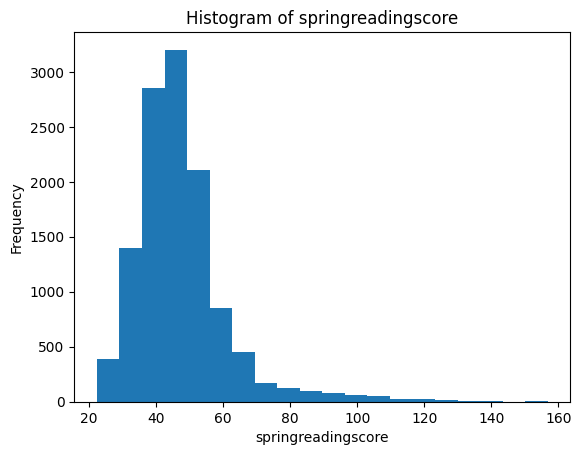

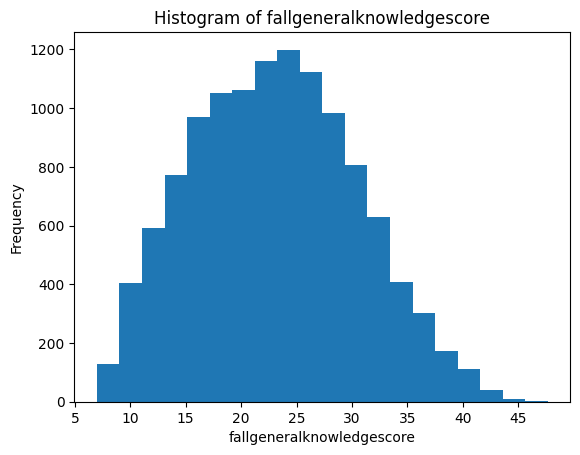

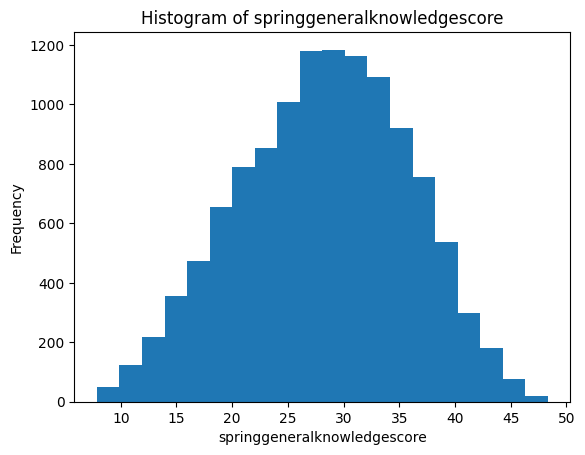

In [45]:
# A function to draw a histogram of a given column
def draw_histogram(column):
    plt.hist(column, bins=20)
    plt.title('Histogram of ' + column.name)
    plt.xlabel(column.name)
    plt.ylabel('Frequency')
    plt.show()

# Draw histograms of all score columns
for column in score_columns:
    draw_histogram(df['fall' + column])
    draw_histogram(df['spring' + column])

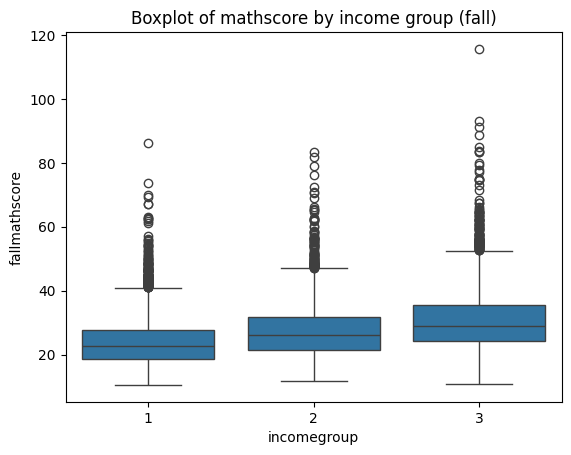

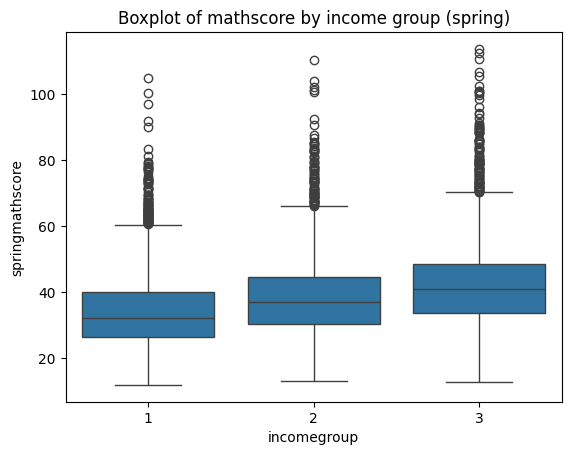

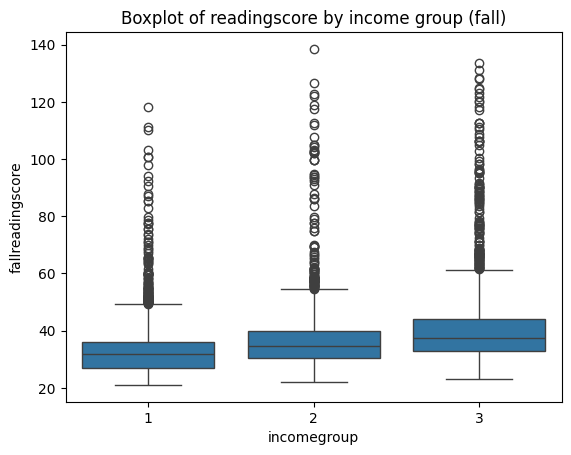

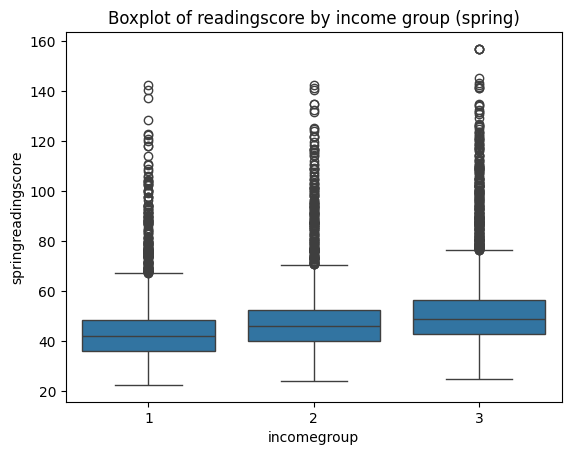

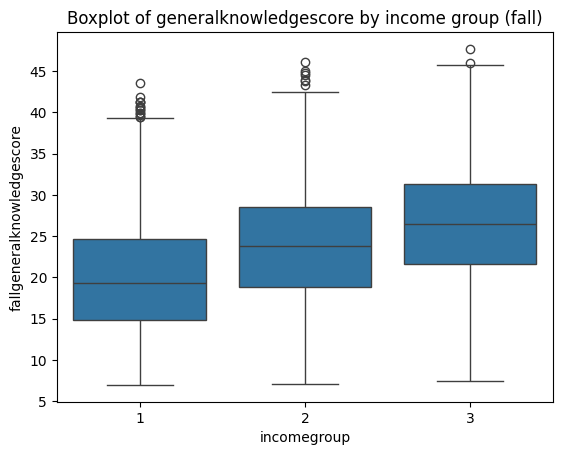

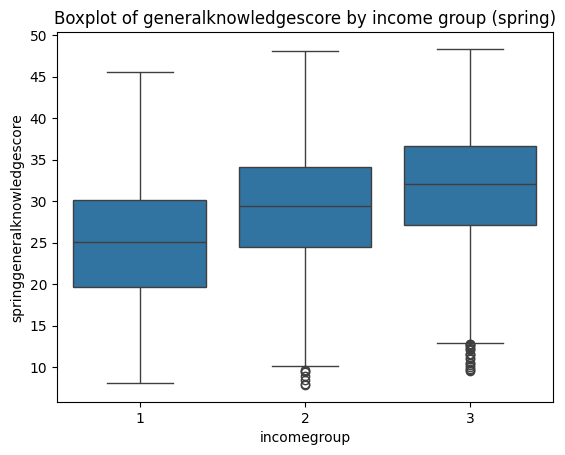

In [46]:
# Draw boxplot for each type of score, grouped by income group
def draw_boxplot(df, column):
    for season in ['fall', 'spring']:
        sns.boxplot(
            x='incomegroup',
            y=season + column,
            data=df
        )
        plt.title('Boxplot of ' + column + ' by income group (' + season + ')')
        plt.show()

for column in score_columns:
    draw_boxplot(df, column)

## Analysis of Covariance (ANCOVA)

### Assumption 1 - Linearity of the relationship between the dependent variable and the covariant

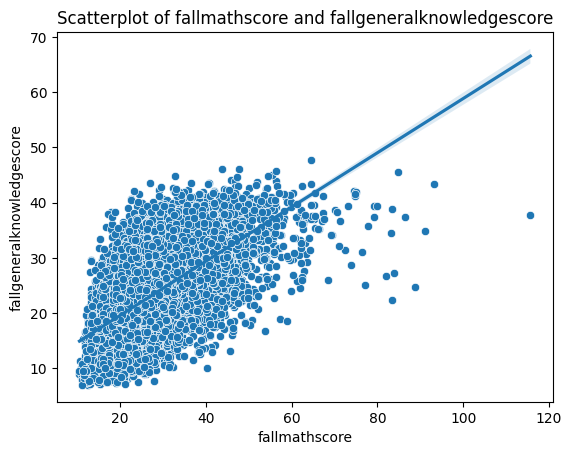

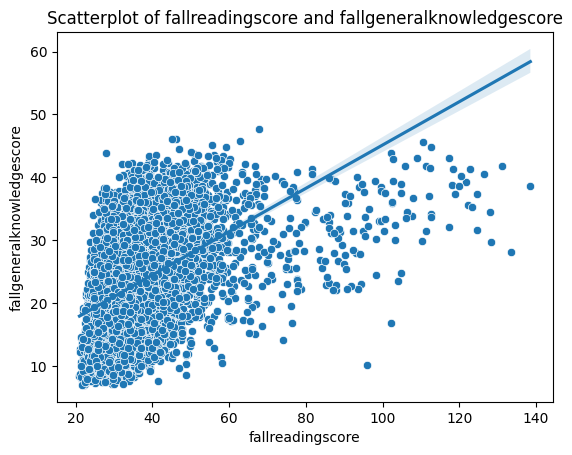

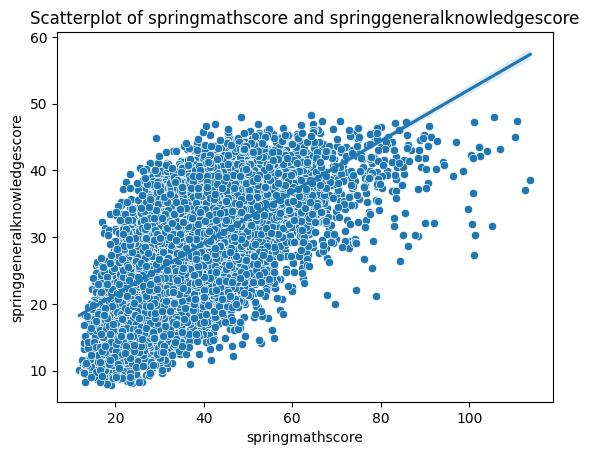

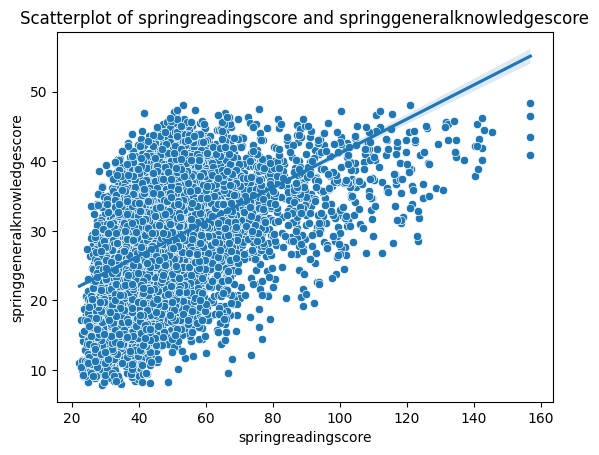

In [47]:
# Test the assumption of linearity between the fall and spring scores
def test_linearity(df, columnA, columnB):
    sns.scatterplot(
        x=columnA,
        y=columnB,
        data=df
    )
    sns.regplot(
        x=columnA,
        y=columnB,
        data=df,
        scatter=False
    )
    plt.title('Scatterplot of ' + columnA + ' and ' + columnB)
    plt.show()

for columnA, columnB in [
    ('fallmathscore', 'fallgeneralknowledgescore'),
    ('fallreadingscore', 'fallgeneralknowledgescore'),
    ('springmathscore', 'springgeneralknowledgescore'),
    ('springreadingscore', 'springgeneralknowledgescore')
]:
    test_linearity(df, columnA, columnB)

In [48]:
# Use OLS regression to test the relationship between fall and spring scores
import statsmodels.api as sm

dep_covariate_pairs = [
    ('fallmathscore', 'fallgeneralknowledgescore'),
    ('fallreadingscore', 'fallgeneralknowledgescore'),
    ('springmathscore', 'springgeneralknowledgescore'),
    ('springreadingscore', 'springgeneralknowledgescore')
]

def test_relationship(df, columnA, columnB):
    print("=" * 40)
    print("test_relationship", columnA, columnB)
    X = sm.add_constant(df[columnA])
    Y = df[columnB]
    model = sm.OLS(Y, X).fit()
    print(model.summary())
    print()

for columnA, columnB in dep_covariate_pairs:
    test_relationship(df, columnA, columnB)


test_relationship fallmathscore fallgeneralknowledgescore
                                OLS Regression Results                               
Dep. Variable:     fallgeneralknowledgescore   R-squared:                       0.366
Model:                                   OLS   Adj. R-squared:                  0.366
Method:                        Least Squares   F-statistic:                     6896.
Date:                       Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                               19:57:29   Log-Likelihood:                -38089.
No. Observations:                      11933   AIC:                         7.618e+04
Df Residuals:                          11931   BIC:                         7.620e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]


### Assumption 2 - Homogeneity of regression slopes

In [49]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

def test_homo(df, columnA, columnB):
    print("=" * 40)
    print('test_homo', columnA, columnB)
    print(anova_lm(
        ols(columnA + ' ~ ' + columnB + ' * incomegroup', data = df).fit(),
        type = 3
    ))
    print()

for columnA, columnB in dep_covariate_pairs:
    test_homo(df, columnA, columnB)

test_homo fallmathscore fallgeneralknowledgescore
                                            df         sum_sq        mean_sq  \
incomegroup                                2.0  101740.378103   50870.189052   
fallgeneralknowledgescore                  1.0  273412.600276  273412.600276   
fallgeneralknowledgescore:incomegroup      2.0    1083.808214     541.904107   
Residual                               11927.0  616310.080790      51.673521   

                                                 F    PR(>F)  
incomegroup                             984.453709  0.000000  
fallgeneralknowledgescore              5291.154867  0.000000  
fallgeneralknowledgescore:incomegroup    10.487075  0.000028  
Residual                                       NaN       NaN  

test_homo fallreadingscore fallgeneralknowledgescore
                                            df         sum_sq        mean_sq  \
incomegroup                                2.0  101978.658155   50989.329077   
fallgeneralknowledge

### Assumption 3 - Normality of residuals

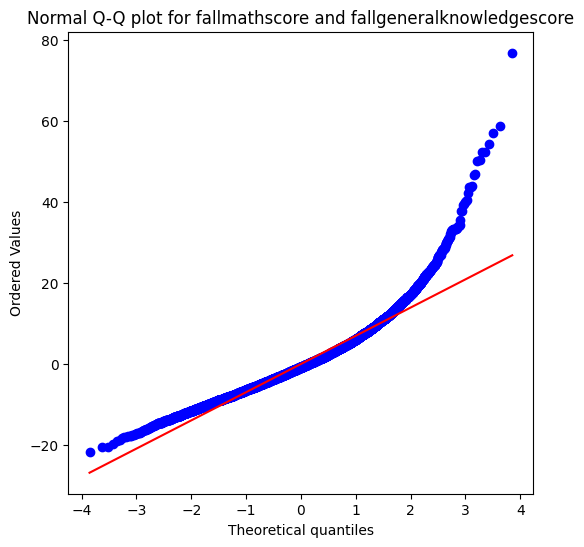

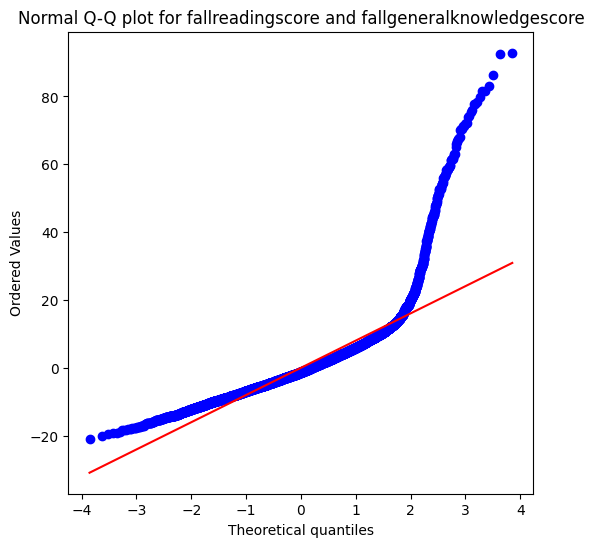

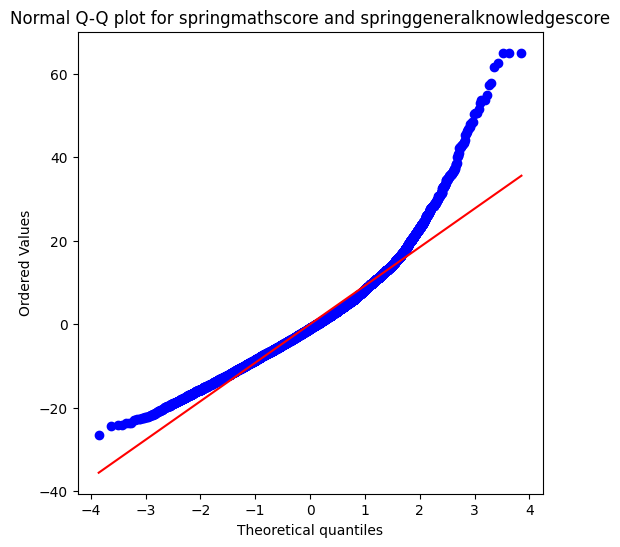

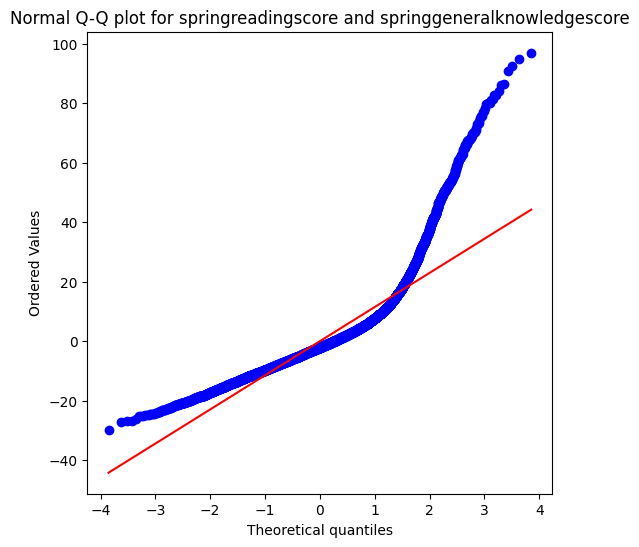

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import probplot

def draw_qq_plot_residuals(df, columnA, columnB):
    m = ols(columnA + ' ~ ' + columnB + ' + incomegroup', data = df).fit()
    residuals = m.resid

    # Draw QQ plot for residuals
    plt.figure(figsize=(6,6))
    probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot for " + columnA + " and " + columnB)
    plt.show()

# Draw QQ plot for all residuals
for columnA, columnB in dep_covariate_pairs:
    draw_qq_plot_residuals(df, columnA, columnB)

In [51]:
from scipy import stats as sm

# Use shapiro-wilk test to verify the normality
def do_shapiro_wilk_test(df, columnA, columnB):
    m = ols(columnA + ' ~ ' + columnB + ' + incomegroup', data = df).fit()
    residuals = m.resid
    print("Shapiro-Wilk test for " + columnA + " and " + columnB)
    print(sm.shapiro(residuals))

for columnA, columnB in dep_covariate_pairs:
    do_shapiro_wilk_test(df, columnA, columnB)

Shapiro-Wilk test for fallmathscore and fallgeneralknowledgescore
ShapiroResult(statistic=0.936102305196568, pvalue=2.841944153576944e-57)
Shapiro-Wilk test for fallreadingscore and fallgeneralknowledgescore
ShapiroResult(statistic=0.782790806712133, pvalue=1.935081472005383e-82)
Shapiro-Wilk test for springmathscore and springgeneralknowledgescore
ShapiroResult(statistic=0.9483254834788736, pvalue=2.205169742899097e-53)
Shapiro-Wilk test for springreadingscore and springgeneralknowledgescore
ShapiroResult(statistic=0.8265715400613723, pvalue=1.8556095848561697e-77)


/var/folders/b7/wmff38bn3j30f9zq_6xn4p680000gn/T/ipykernel_94321/699490488.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11933.
  print(sm.shapiro(residuals))
/var/folders/b7/wmff38bn3j30f9zq_6xn4p680000gn/T/ipykernel_94321/699490488.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11933.
  print(sm.shapiro(residuals))
/var/folders/b7/wmff38bn3j30f9zq_6xn4p680000gn/T/ipykernel_94321/699490488.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11933.
  print(sm.shapiro(residuals))
/var/folders/b7/wmff38bn3j30f9zq_6xn4p680000gn/T/ipykernel_94321/699490488.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11933.
  print(sm.shapiro(residuals))


### Assumption 4 - Homogeneity of variance

In [53]:
# Compute residuals for all models and do a Levene's test

def get_residual(df, columnA, columnB):
    m = ols(columnA + ' ~ ' + columnB + ' + incomegroup', data = df).fit()
    return m.resid

residuals = []
for columnA, columnB in dep_covariate_pairs:
    residual = get_residual(df, columnA, columnB)
    residuals.append(residual)

print("Levene's test for residuals")
print(sm.levene(residuals[0], residuals[1], residuals[2], residuals[3]))

Levene's test for residuals
LeveneResult(statistic=372.90857772536845, pvalue=1.9806531381037137e-239)


## ANCOVA

In [56]:
# Function to do ANCOVA using statsmodels
def ancova_stats_models(df, columnA, columnB):
    print("=" * 40)
    print("ancova_stats_models", columnA, columnB)
    m = ols(columnA + ' ~ ' + columnB + ' + incomegroup', data = df).fit()
    print(m.summary())
    print()

for columnA, columnB in dep_covariate_pairs:
    ancova_stats_models(df, columnA, columnB)

ancova_stats_models fallmathscore fallgeneralknowledgescore
                            OLS Regression Results                            
Dep. Variable:          fallmathscore   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     2416.
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:03:13   Log-Likelihood:                -40477.
No. Observations:               11933   AIC:                         8.096e+04
Df Residuals:                   11929   BIC:                         8.099e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------